In [17]:
# %% [markdown]
# # Compiler Scaling Analysis
# How compiler performance changes with problem size (number of vertices)

# %% Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from pathlib import Path
import json

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# %% Data Loading
def load_scaling_data(db_path: str) -> pd.DataFrame:
    """
    Load compiler results with vertex counts for scaling analysis.
    """
    conn = sqlite3.connect(db_path)
    
    query = """
    SELECT 
        problem_id,
        compiler_name,
        success,
        
        -- Timing
        synthesis_time,
        pipeline_time,
        
        -- High-level metrics
        high_level_qubits,
        high_level_depth,
        high_level_entangling,
        
        -- Low-level metrics  
        low_level_qubits,
        low_level_depth,
        low_level_entangling,
        
        -- Metadata
        trial_params
    FROM compilation_results
    WHERE success = 1
    """
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    
    # Extract clique size from trial_params
    df['clique_size'] = df['trial_params'].apply(
        lambda x: json.loads(x).get('clique_size', None)
    )
    
    # Load problem information to get vertex counts
    # Adjust path as needed - this assumes problems DB is in shared folder
    problems_db_path = '../benchmarklib/shared/problems/clique.db'
    if not Path(problems_db_path).exists():
        problems_db_path = 'shared/problems/clique_problems.db'
    
    conn = sqlite3.connect(problems_db_path)
    problems_query = """
    SELECT 
        instance_id as problem_id,
        size_metrics
    FROM problem_instances
    """
    problems_df = pd.read_sql_query(problems_query, conn)
    conn.close()
    
    # Extract vertex count
    problems_df['num_vertices'] = problems_df['size_metrics'].apply(
        lambda x: json.loads(x).get('num_vertices', None)
    )
    
    # Merge to get vertex counts
    df = df.merge(problems_df[['problem_id', 'num_vertices']], on='problem_id', how='left')
    
    # Calculate derived metrics
    df['high_level_area'] = df['high_level_qubits'] * df['high_level_depth']
    df['low_level_area'] = df['low_level_qubits'] * df['low_level_depth']
    df['total_time'] = df['synthesis_time'] + df['pipeline_time']
    
    return df

# %% Main Scaling Plot
def plot_scaling_analysis(df: pd.DataFrame, save_path=None):
    """
    Create main scaling plots showing how metrics change with vertex count.
    """
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    fig.suptitle('Compiler Scaling Analysis', fontsize=16, y=1.02)
    
    # Define metrics to plot
    metrics = [
        ('low_level_qubits', 'Number of Qubits', axes[0, 0], False),
        ('low_level_depth', 'Circuit Depth', axes[0, 1], True),
        ('low_level_entangling', 'Entangling Gates', axes[0, 2], True),
        ('low_level_area', 'Circuit Area (Q × D)', axes[1, 0], True),
        ('total_time', 'Total Time (s)', axes[1, 1], False),
    ]
    
    # Setup colors and markers for each compiler
    compilers = sorted(df['compiler_name'].unique())
    colors = dict(zip(compilers, plt.cm.tab10(np.linspace(0, 0.8, len(compilers)))))
    markers = dict(zip(compilers, ['o', 's', '^', 'D', 'v', 'p', '*', 'h']))
    
    for metric, title, ax, use_log in metrics:
        for compiler in compilers:
            compiler_df = df[df['compiler_name'] == compiler]
            
            # Group by vertex count and calculate statistics
            grouped = compiler_df.groupby('num_vertices')[metric].agg(['mean', 'std', 'count'])
            grouped = grouped.reset_index()
            
            if len(grouped) > 0:
                x = grouped['num_vertices']
                y = grouped['mean']
                yerr = grouped['std']
                
                # Plot with error bars
                ax.errorbar(x, y, yerr=yerr,
                           marker=markers[compiler],
                           markersize=7,
                           linewidth=2,
                           capsize=3,
                           label=compiler,
                           color=colors[compiler],
                           alpha=0.8)
        
        ax.set_xlabel('Number of Vertices', fontsize=11)
        ax.set_ylabel(title, fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=9)
        
        if use_log:
            ax.set_yscale('log')
            ax.set_ylabel(f'{title} (log scale)', fontsize=11)
    
    # Use the last subplot for a summary table
    ax = axes[1, 2]
    ax.axis('off')
    
    # Create summary statistics
    summary_data = []
    for compiler in compilers:
        compiler_df = df[df['compiler_name'] == compiler]
        vertex_range = f"{compiler_df['num_vertices'].min()}-{compiler_df['num_vertices'].max()}"
        n_samples = len(compiler_df)
        
        # Get average metrics at max vertex count
        max_v = compiler_df['num_vertices'].max()
        max_df = compiler_df[compiler_df['num_vertices'] == max_v]
        
        summary_data.append([
            compiler,
            vertex_range,
            n_samples,
            f"{max_df['low_level_depth'].mean():.0f}",
            f"{max_df['total_time'].mean():.2f}s"
        ])
    
    table = ax.table(cellText=summary_data,
                    colLabels=['Compiler', 'Vertices', 'Samples', f'Depth @ max', f'Time @ max'],
                    cellLoc='center',
                    loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# %% High vs Low Level Comparison
def plot_high_vs_low_scaling(df: pd.DataFrame, save_path=None):
    """
    Compare high-level vs low-level metrics scaling.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('High-Level vs Low-Level Metrics Scaling', fontsize=16, y=1.02)
    
    metrics = [
        ('qubits', 'Number of Qubits'),
        ('depth', 'Circuit Depth'),
        ('entangling', 'Entangling Gates'),
    ]
    
    compilers = sorted(df['compiler_name'].unique())
    colors = dict(zip(compilers, plt.cm.tab10(np.linspace(0, 0.8, len(compilers)))))
    
    
    for ax, (metric_base, title) in zip(axes, metrics):
        for compiler in compilers:
            compiler_df = df[df['compiler_name'] == compiler]
            
            # High-level metrics
            high_grouped = compiler_df.groupby('num_vertices')[f'high_level_{metric_base}'].mean()
            # Low-level metrics
            low_grouped = compiler_df.groupby('num_vertices')[f'low_level_{metric_base}'].mean()
            
            if len(high_grouped) > 0:
                x = high_grouped.index
                
                # Plot high-level with dashed lines
                ax.plot(x, high_grouped.values, 
                       linestyle='--', 
                       marker='o',
                       markersize=5,
                       color=colors[compiler],
                       alpha=0.5,
                       linewidth=1.5)
                
                # Plot low-level with solid lines
                ax.plot(x, low_grouped.values,
                       linestyle='-',
                       marker='s',
                       markersize=5,
                       color=colors[compiler],
                       label=compiler,
                       linewidth=2,
                       alpha=0.8)
        
        ax.set_xlabel('Number of Vertices', fontsize=11)
        ax.set_ylabel(title, fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best', fontsize=9)
        
        # Add text to indicate line styles
        ax.text(0.02, 0.98, 'Dashed: High-level\nSolid: Low-level',
               transform=ax.transAxes,
               fontsize=8,
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        if metric_base in ['depth', 'entangling']:
            ax.set_yscale('log')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# %% Individual Metric Focus
def plot_metric_focus(df: pd.DataFrame, metric: str, title: str, log_scale=False, save_path=None):
    """
    Focus plot on a single metric across all compilers.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle(f'Scaling Analysis: {title}', fontsize=14)
    
    compilers = sorted(df['compiler_name'].unique())
    colors = dict(zip(compilers, plt.cm.tab10(np.linspace(0, 0.8, len(compilers)))))
    markers = dict(zip(compilers, ['o', 's', '^', 'D', 'v', 'p', '*', 'h']))
    
    for compiler in compilers:
        compiler_df = df[df['compiler_name'] == compiler]
        
        # Group by vertex count
        grouped = compiler_df.groupby('num_vertices')[metric].agg(['mean', 'std', 'count'])
        grouped = grouped.reset_index()
        
        if len(grouped) > 0:
            x = grouped['num_vertices']
            y = grouped['mean']
            yerr = grouped['std']
            
            # Main plot with error bars
            ax.errorbar(x, y, yerr=yerr,
                       marker=markers[compiler],
                       markersize=8,
                       linewidth=2.5,
                       capsize=4,
                       label=f"{compiler} (n={grouped['count'].sum()})",
                       color=colors[compiler],
                       alpha=0.8)
            
            # Add scatter of individual points
            ax.scatter(compiler_df['num_vertices'], compiler_df[metric],
                      alpha=0.2, s=15, color=colors[compiler])
    
    ax.set_xlabel('Number of Vertices', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='best', fontsize=10)
    
    if log_scale:
        ax.set_yscale('log')
        ax.set_ylabel(f'{title} (log scale)', fontsize=12)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# %% Print Scaling Statistics
def print_scaling_statistics(df: pd.DataFrame):
    """
    Print detailed scaling statistics for each compiler.
    """
    print("\n" + "="*80)
    print("SCALING STATISTICS BY COMPILER")
    print("="*80)
    
    for compiler in sorted(df['compiler_name'].unique()):
        compiler_df = df[df['compiler_name'] == compiler]
        
        print(f"\n{compiler}")
        print("-"*40)
        
        # Group by vertex count
        grouped = compiler_df.groupby('num_vertices').agg({
            'low_level_depth': ['mean', 'std', 'count'],
            'low_level_entangling': 'mean',
            'low_level_area': 'mean',
            'total_time': 'mean'
        }).round(2)
        
        print(grouped)
        
        # Calculate growth from min to max
        min_v = compiler_df['num_vertices'].min()
        max_v = compiler_df['num_vertices'].max()
        
        if min_v != max_v:
            min_depth = compiler_df[compiler_df['num_vertices'] == min_v]['low_level_depth'].mean()
            max_depth = compiler_df[compiler_df['num_vertices'] == max_v]['low_level_depth'].mean()
            
            min_time = compiler_df[compiler_df['num_vertices'] == min_v]['total_time'].mean()
            max_time = compiler_df[compiler_df['num_vertices'] == max_v]['total_time'].mean()
            
            print(f"\nGrowth from n={min_v} to n={max_v}:")
            print(f"  Depth: {min_depth:.0f} → {max_depth:.0f} ({max_depth/min_depth:.1f}x)")
            print(f"  Time:  {min_time:.3f}s → {max_time:.3f}s ({max_time/min_time:.1f}x)")

# %% Main Analysis Function
def run_scaling_analysis(db_path: str, output_dir=None):
    """
    Run complete scaling analysis.
    """
    print(f"Loading data from: {db_path}")
    
    df = load_scaling_data(db_path)
    
    print(f"\nLoaded {len(df)} successful compilations")
    print(f"Compilers: {df['compiler_name'].unique().tolist()}")
    print(f"Vertex range: {df['num_vertices'].min()} to {df['num_vertices'].max()}")
    
    if len(df) == 0:
        print("No data found!")
        return df
    
    # Create output directory
    if output_dir:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Print statistics
    print_scaling_statistics(df)
    
    # Generate plots
    print("\nGenerating plots...")
    
    # 1. Main scaling analysis
    plot_scaling_analysis(df, 
                         save_path=f"{output_dir}/scaling_main.png" if output_dir else None)
    
    # 2. High vs Low level comparison
    plot_high_vs_low_scaling(df,
                            save_path=f"{output_dir}/scaling_high_vs_low.png" if output_dir else None)
    
    # 3. Individual metric focus plots
    plot_metric_focus(df, 'low_level_depth', 'Circuit Depth', log_scale=True,
                     save_path=f"{output_dir}/scaling_depth.png" if output_dir else None)
    
    plot_metric_focus(df, 'low_level_area', 'Circuit Area (Qubits × Depth)', log_scale=True,
                     save_path=f"{output_dir}/scaling_area.png" if output_dir else None)
    
    plot_metric_focus(df, 'total_time', 'Compilation Time', log_scale=False,
                     save_path=f"{output_dir}/scaling_time.png" if output_dir else None)
    
    return df



Loading data from: project_benchmarks/results.db

Loaded 23833 successful compilations
Compilers: ['XAGSynthesizer', 'TruthTableSynthesizer', 'ClassiqSynthesizer', 'XAGSynthesizer+ReplaceCCXwithRCCX+ReplaceCRXwithCX']
Vertex range: 3 to 15

SCALING STATISTICS BY COMPILER

ClassiqSynthesizer
----------------------------------------
             low_level_depth                low_level_entangling  \
                        mean      std count                 mean   
num_vertices                                                       
3                    1168.50   247.24   689               399.47   
4                    2437.92   385.00   658               874.99   
5                    3051.14   490.99   500              1139.16   
6                    4032.29   734.59   647              1560.53   
7                    4728.67   932.85   657              1906.98   
8                    6918.24  1262.36   646              2923.26   
9                    8038.92  1552.35   499            

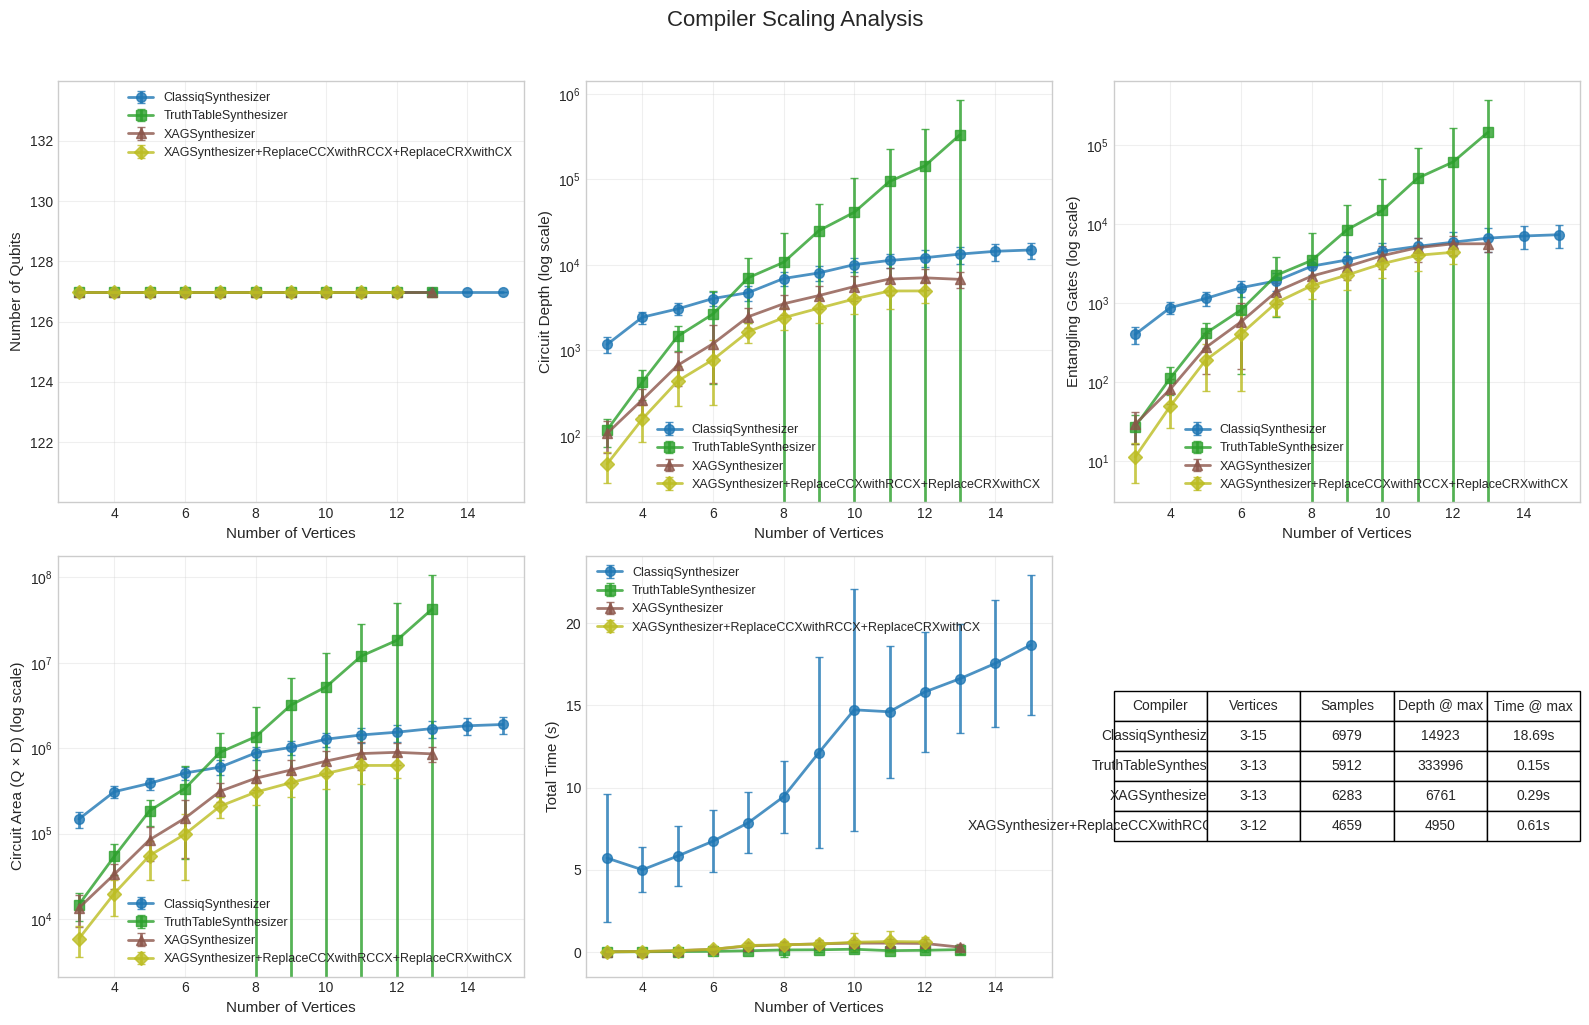

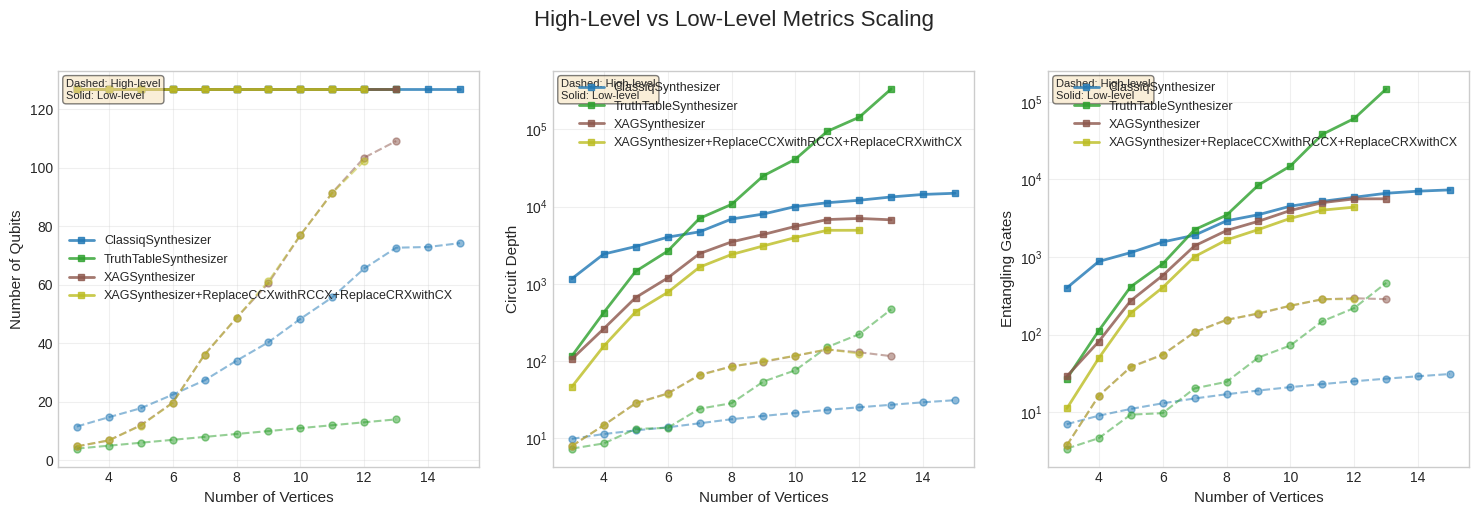

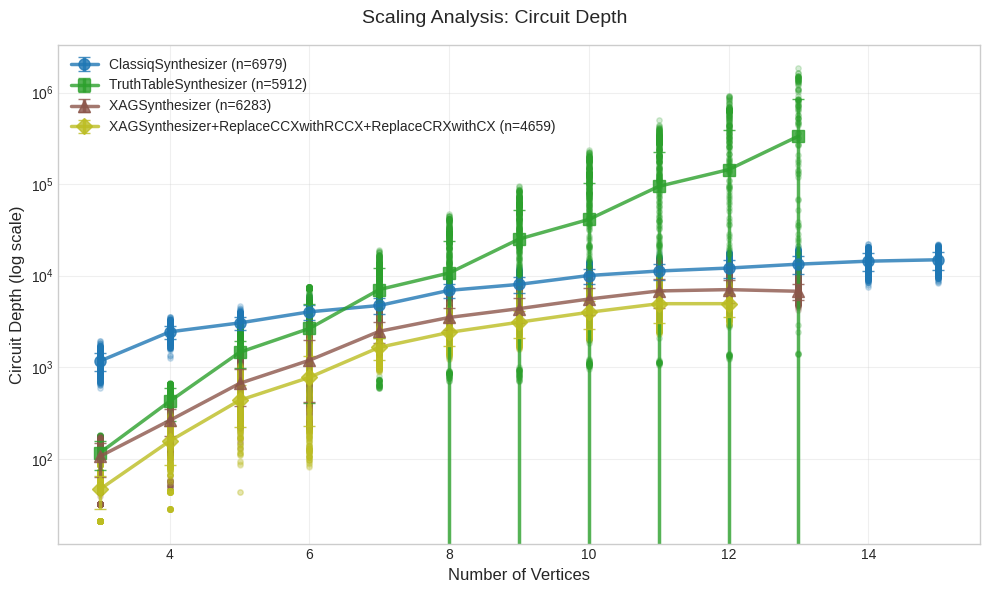

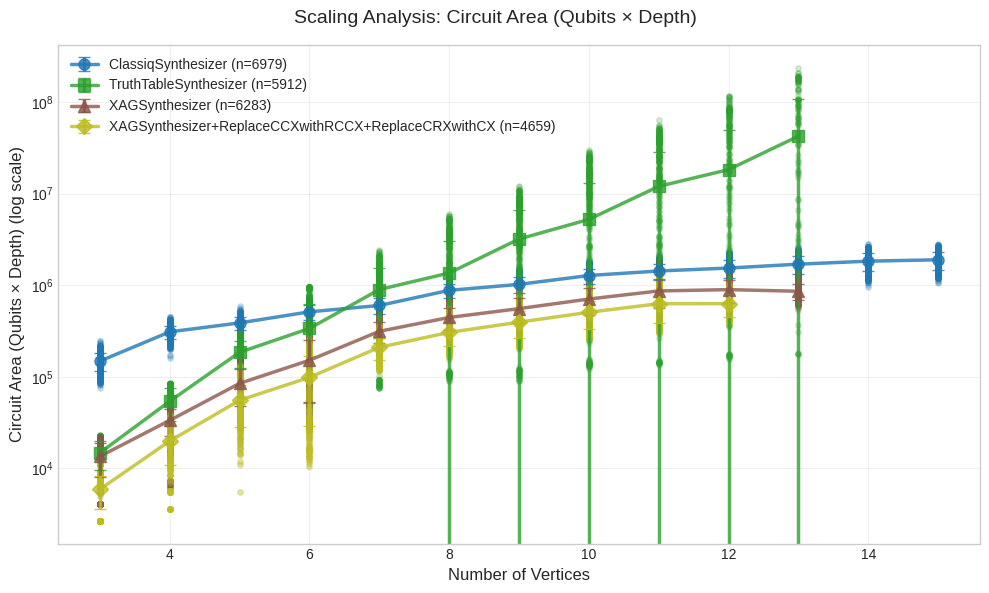

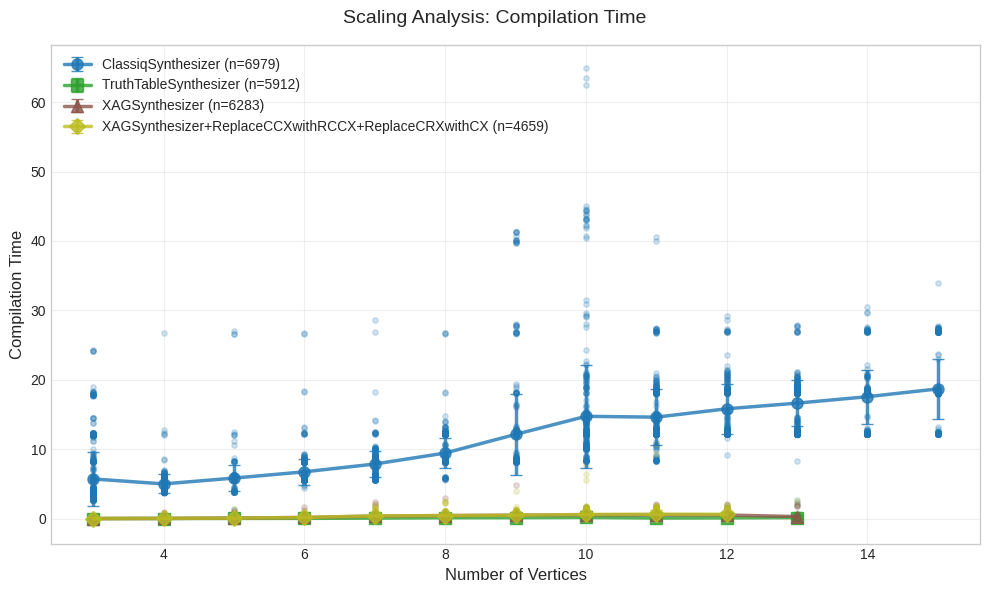


Analysis complete! Generated 5 plots


In [18]:

# Configuration
DB_PATH = "project_benchmarks/results.db"
OUTPUT_DIR = "scaling_plots"

# Run the analysis
df = run_scaling_analysis(DB_PATH, OUTPUT_DIR)

print(f"\nAnalysis complete! Generated {5} plots")